In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_raw_ts(path, dataset, tensor_format=True):
    path = path + "raw/" + dataset + "/"
    x_train = np.load(path + 'X_train.npy')
    y_train = np.load(path + 'y_train.npy')
    x_test = np.load(path + 'X_test.npy')
    y_test = np.load(path + 'y_test.npy')
    ts = np.concatenate((x_train, x_test), axis=0)
    ts = np.transpose(ts, axes=(0, 1, 2))
    labels = np.concatenate((y_train, y_test), axis=0)
    nclass = int(np.amax(labels)) + 1


    train_size = y_train.shape[0]

    total_size = labels.shape[0]
    idx_train = range(train_size)
    idx_val = range(train_size, total_size)
    idx_test = range(train_size, total_size)

    if tensor_format:
        # features = torch.FloatTensor(np.array(features))
        ts = torch.FloatTensor(np.array(ts))
        labels = torch.LongTensor(labels)

        idx_train = torch.LongTensor(idx_train)
        idx_val = torch.LongTensor(idx_val)
        idx_test = torch.LongTensor(idx_test)

    return ts, labels, idx_train, idx_val, idx_test, nclass


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap='crest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
import math
from typing import Optional, Any
from torch.utils.data import DataLoader
from torch import optim
from sklearn.metrics import accuracy_score
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer

In [5]:
def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    raise ValueError("activation should be relu/gelu, not {}".format(activation))

    
def get_pos_encoder(pos_encoding):
    if pos_encoding == "learnable":
        return LearnablePositionalEncoding
    elif pos_encoding == "fixed":
        return FixedPositionalEncoding

    raise NotImplementedError("pos_encoding should be 'learnable'/'fixed', not '{}'".format(pos_encoding))

In [6]:
class FixedPositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(FixedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = scale_factor * pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
class LearnablePositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=1024):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Each position gets its own embedding
        # Since indices are always 0 ... max_len, we don't have to do a look-up
        self.pe = nn.Parameter(torch.empty(max_len, 1, d_model))  # requires_grad automatically set to True
        nn.init.uniform_(self.pe, -0.02, 0.02)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:
class TransformerBatchNormEncoderLayer(nn.modules.Module):
    r"""This transformer encoder layer block is made up of self-attn and feedforward network.
    It differs from TransformerEncoderLayer in torch/nn/modules/transformer.py in that it replaces LayerNorm
    with BatchNorm.
    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerBatchNormEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = BatchNorm1d(d_model, eps=1e-5)  # normalizes each feature across batch samples and time steps
        self.norm2 = BatchNorm1d(d_model, eps=1e-5)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerBatchNormEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        # src = src.reshape([src.shape[0], -1])  # (batch_size, seq_length * d_model)
        src = self.norm1(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        src = self.norm2(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        return src


In [9]:
class TSTransformerEncoder(nn.Module):

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward, dropout=0.1,
                 pos_encoding='learnable', activation='gelu', norm='BatchNorm', freeze=False):
        super(TSTransformerEncoder, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.feat_dim = feat_dim
        

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output_layer = nn.Linear(d_model, feat_dim)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)


    def forward(self, X, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, seq_length, feat_dim)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        output = self.transformer_encoder(inp, src_key_padding_mask=~padding_masks)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output) ## Z
        # Most probably defining a Linear(d_model,feat_dim) vectorizes the operation over (seq_length, batch_size).
        output = self.output_layer(output)  # (batch_size, seq_length, feat_dim)

        return output



In [10]:
class TSTransformerEncoderClass(nn.Module):
    """
    Simplest classifier/regressor. Can be either regressor or classifier because the output does not include
    softmax. Concatenates final layer embeddings and uses 0s to ignore padding embeddings in final output layer.
    """

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward, num_classes,
                 dropout=0.1, pos_encoding='learnable', activation='gelu', norm='BatchNorm', freeze=False):
        super(TSTransformerEncoderClass, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.output_layer = self.build_output_module(d_model, max_len, num_classes)

    def build_output_module(self, d_model, max_len, num_classes):
        output_layer = nn.Linear(d_model * max_len, num_classes)
        # no softmax (or log softmax), because CrossEntropyLoss does this internally. If probabilities are needed,
        # add F.log_softmax and use NLLoss
        return output_layer

    def forward(self, X, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, num_classes)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        output = self.transformer_encoder(inp, src_key_padding_mask=~padding_masks)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output)

        # Output
        output = output * padding_masks.unsqueeze(-1)  # zero-out padding embeddings
        output = output.reshape(output.shape[0], -1)  # (batch_size, seq_length * d_model)
        output = self.output_layer(output)  # (batch_size, num_classes)

        return output

In [11]:
def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)
    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask


In [12]:
def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked
    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask


In [13]:
def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max_val()  # trick works because of overloading of 'or' operator for non-boolean types
    return (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))

In [14]:
def compensate_masking(X, mask):
    """
    Compensate feature vectors after masking values, in a way that the matrix product W @ X would not be affected on average.
    If p is the proportion of unmasked (active) elements, X' = X / p = X * feat_dim/num_active
    Args:
        X: (batch_size, seq_length, feat_dim) torch tensor
        mask: (batch_size, seq_length, feat_dim) torch tensor: 0s means mask and predict, 1s: unaffected (active) input
    Returns:
        (batch_size, seq_length, feat_dim) compensated features
    """

    # number of unmasked elements of feature vector for each time step
    num_active = torch.sum(mask, dim=-1).unsqueeze(-1)  # (batch_size, seq_length, 1)
    # to avoid division by 0, set the minimum to 1
    num_active = torch.max(num_active, torch.ones(num_active.shape, dtype=torch.int16))  # (batch_size, seq_length, 1)
    return X.shape[-1] * X / num_active

In [15]:
def collate_unsuperv(data, mask, max_len=None, mask_compensation=False):
    """Build mini-batch tensors from a list of (X, mask) tuples. Mask input. Create
    Args:
        data: len(batch_size) list of tuples (X, mask).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - mask: boolean torch tensor of shape (seq_length, feat_dim); variable seq_length.
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        targets: (batch_size, padded_length, feat_dim) torch tensor of unmasked features (output)
        target_masks: (batch_size, padded_length, feat_dim) boolean torch tensor
            0 indicates masked values to be predicted, 1 indicates unaffected/"active" feature values
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 ignore (padding)
    """

    batch_size = len(data)
    features, masks = data, mask

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)
    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)
    target_masks = torch.zeros_like(X,
                                    dtype=torch.bool)  # (batch_size, padded_length, feat_dim) masks related to objective
    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]
        target_masks[i, :end, :] = masks[i][:end, :]

    targets = X.clone()
    X = X * target_masks  # mask input
    if mask_compensation:
        X = compensate_masking(X, target_masks)

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep
    target_masks = ~target_masks  # inverse logic: 0 now means ignore, 1 means predict
    return X, targets, target_masks, padding_masks

In [16]:
class MaskedMSELoss(nn.Module):
    """ Masked MSE Loss
    """

    def __init__(self, reduction: str = 'mean'):

        super().__init__()

        self.reduction = reduction
        self.mse_loss = nn.MSELoss(reduction=self.reduction)

    def forward(self,
                y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
        """Compute the loss between a target value and a prediction.
        Args:
            y_pred: Estimated values
            y_true: Target values
            mask: boolean tensor with 0s at places where values should be ignored and 1s where they should be considered
        Returns
        -------
        if reduction == 'none':
            (num_active,) Loss for each active batch element as a tensor with gradient attached.
        if reduction == 'mean':
            scalar mean loss over batch as a tensor with gradient attached.
        """

        # for this particular loss, one may also elementwise multiply y_pred and y_true with the inverted mask
        masked_pred = torch.masked_select(y_pred, mask)
        masked_true = torch.masked_select(y_true, mask)

        return self.mse_loss(masked_pred, masked_true)

In [17]:
class train_model():
    
    def __init__(self,model):
        self.model = model
        self.epoch_metrics = {}
        self.total_accuracy = 0
        self.batch_loss = []
        
    def compile(self, loss=nn.CrossEntropyLoss(),optimizer=optim.Adam,lr=0.0001):  
        self.loss_module = loss
        self.optimizer = optimizer(self.model.parameters(),lr=lr)

   
    def train(self,data, batch_size=128,epochs=100,verbose=True,return_loss=False):
        self.model = self.model.train()
        self.data = data
        self.verbose = verbose
        self.return_loss = return_loss
        self.batch_size = batch_size
        self.epochs = epochs
  

        for epoch in range(self.epochs):
    
            total_batch_accuracy = 0
            total_loss = 0
    
            for i, batch in enumerate(DataLoader(self.data,self.batch_size)):
                x_train, y_train, masks = batch
                prediction = self.model(x_train.float(),masks)
                prob = nn.Softmax(prediction)
                #optimizer = self.optimizer(self.model.parameters())
                loss = self.loss_module(prediction, y_train)
        
                total_loss += loss
                mean_batch_loss = total_loss/(i+1)
        
                predictions = torch.argmax(prediction, 1)
                batch_accuracy = accuracy_score(y_train, predictions)
        
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=4.0)
                self.optimizer.step()
        
                total_batch_accuracy += batch_accuracy 
                mean_bach_accuracy = total_batch_accuracy/(i+1)
                metrics = {'mean batch accuracy':mean_bach_accuracy.item()}
        
        
            self.batch_loss.append(mean_batch_loss.detach().numpy())
            if self.verbose:
                print('\033[94m'+'Epoch {}:'.format(epoch)+'\033[0m'+' {}%'.format(round(mean_bach_accuracy*100,3)))
            self.total_accuracy += mean_bach_accuracy
            self.epoch_metrics['Epoch'] = epoch
            self.epoch_metrics['Accuracy'] = self.total_accuracy/(epoch+1)
        
        if self.return_loss:
            return plt.plot(self.batch_loss)
        
        
    def evaluate(self,data,batch_size=128, return_loss=False):
            self.data = data
            self.batch_size = batch_size
            total_batch_accuracy = 0
            self.model = self.model.eval()
            
            for i, batch in enumerate(DataLoader(self.data, self.batch_size)):
                x_test, y_test, masks = batch
                prediction = self.model(x_test.float(), masks)
               # prob = nn.Softmax(prediction)
                predictions = torch.argmax(prediction,1)
                batch_accuracy = accuracy_score(y_test,predictions)
                loss = self.loss_module(prediction, y_test)
                
                total_batch_accuracy += batch_accuracy 
                mean_bach_accuracy = total_batch_accuracy/(i+1)

            metrics = {'mean batch accuracy':mean_bach_accuracy.item()}
            
            return metrics
           
        
    def analyze(self,data,color='viridis'):
        self.data = data
        self.model = self.model.eval()
        
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,                                    roc_curve, roc_auc_score
        for i, batch in enumerate(DataLoader(self.data, 100000)):
                x_test, y_test, masks = batch
                prediction = self.model(x_test.float(), masks)
                predictions = torch.argmax(prediction,1)
                accuracy = accuracy_score(predictions, y_test)
                print('\033[92m'+'\nAccuracy: '+'\033[0m',accuracy)
                print('\n'+'\033[0m'+         'Classification Report:\n')
                print(classification_report(predictions, y_test))
                print('\n'+'\033[0m'+         'Confusion Matrix:\n')
                cm = confusion_matrix(predictions, y_test)
                print('\033[91m'+  '             Total lenght of Data:'+'\033[0m', len(y_test),'\n')
                print('\033[94m'+'             Class 0:'+'\033[0m',                                     (torch.unique(y_test, return_counts=True)[1][0]).item())
                print('\033[94m'+'             Class 1:'+'\033[0m',                                     (torch.unique(y_test, return_counts=True)[1][1]).item(),                                      '\n'+'\033[0m')
                
                plot_confusion_matrix(cm,[0,1],color=color)
                
                print('\n')

                try:
                    fpr, tpr, _ = roc_curve(predictions, y_test)
                    roc_auc = roc_auc_score(predictions, y_test)
                    plt.figure()
                    plt.plot(fpr, tpr, label='(Area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve')
                    plt.legend(loc='best')
                    plt.show()
                    
                except:
                    print('Something wrong')


In [20]:
class TSTransformerEncoderLSTM(nn.Module):
    """
    Simplest classifier/regressor. Can be either regressor or classifier because the output does not include
    softmax. Concatenates final layer embeddings and uses 0s to ignore padding embeddings in final output layer.
    """

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward, num_classes,
                 lstm_layers = 1, hidden_layers=128,
                 dropout=0.1, pos_encoding='learnable', activation='gelu', norm='BatchNorm', freeze=False):
        super(TSTransformerEncoderLSTM, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.lstm_layers = lstm_layers
        self.hidden_size = hidden_layers

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.conv1 = nn.Conv1d(max_len,128,1,padding='same')
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(128,self.hidden_size,self.lstm_layers,batch_first=True)
        self.output_layer = self.linear(num_classes)



    def linear(self,num_classes):
        output_layer = nn.Linear(self.lstm_layers*self.hidden_size,num_classes)
        # no softmax (or log softmax), because CrossEntropyLoss does this internally. If probabilities are needed,
        # add F.log_softmax and use NLLoss
        return output_layer

        
    def forward(self, X, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, num_classes)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        output = self.transformer_encoder(inp, src_key_padding_mask=~padding_masks)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output)
        output = output * padding_masks.unsqueeze(-1)
        #output = self.act(output)
        output = output
       # output = self.pool(output)
        # Output
          # zero-out padding embeddings
        h0=c0= torch.zeros(self.lstm_layers,output.size(0),self.hidden_size)
        output, (hn, cn) = self.lstm(output, (h0,c0))
        hn = hn.view(-1,self.hidden_size*self.lstm_layers)
        output = self.output_layer(hn)
        return output

In [203]:
from dask.distributed import Client

In [204]:
from dask import delayed, compute

In [205]:
def da():
    preprocess = delayed(data_preprocess)().get_data('MSFT',days=10,path = path)
    train, val, test, feat_dim, max_len   = compute(preprocess.prepare_data())

In [207]:
path = '/Users/abhijitdeshpande/Documents/Project Files/Full Hourly Data/'

In [208]:
from preprocess import data_preprocess,train_model

In [209]:
%%time
preprocess = data_preprocess()
preprocess.get_data('MSFT',days=10,path = path)
train, val, test, feat_dim, max_len   = preprocess.prepare_data()

Total Samples: 7689
Training Samples: 2306
Validation Samples: 2691
Testing Samples: 2692
CPU times: user 7.82 s, sys: 484 ms, total: 8.3 s
Wall time: 8.2 s


In [210]:
import torch
import torch.nn as nn

In [231]:
super_model = TSTransformerEncoderLSTM(feat_dim,max_len,128,16,3,
                                             128, 2,lstm_layers=1, hidden_layers=128,dropout=0.1)

In [232]:
model = train_model(super_model)

In [234]:
model.compile(loss=nn.BCEWithLogitsLoss())

In [235]:
model.train(train)

ValueError: Target size (torch.Size([128])) must be the same as input size (torch.Size([128, 2]))

In [236]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion(output, target)  # -log(sigmoid(1.5))

tensor(0.2014)

In [246]:
output

tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1

In [245]:
target

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.,

In [211]:
m = nn.Conv1d(16, 33, 3, stride=1)
input = torch.randn(20, 16, 50)
output = m(input)
output.shape

torch.Size([20, 33, 48])

In [212]:
x = nn.Conv1d(64,64,1,padding='valid')\
    (nn.Conv1d(64,64,3,padding='same')\
     (nn.Conv1d(10,64,kernel_size=1,stride=2,padding='valid')(train[0][0].unsqueeze(-3).float())))

In [213]:
res = train[0][0].unsqueeze(-3).float()

In [214]:
x.shape

torch.Size([1, 64, 23])

In [215]:
res_x.shape

torch.Size([1, 64, 23])

In [216]:
res_x = nn.Conv1d(10,64,1,stride=2,padding='valid')(res)

In [217]:
torch.add(x,res_x).shape

torch.Size([1, 64, 23])

In [218]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, f, s=2):
        super(ResBlock,self).__init__()
        
        
        self.conv1 = nn.Conv1d(ni, nf, kernel_size=1, stride=s,padding='valid')
        self.conv2 = nn.Conv1d(nf, nf, kernel_size=f,stride=1,padding='same')
        self.conv3 = nn.Conv1d(nf, nf, kernel_size=1,stride=1,padding='valid')

        # expand channels for the sum if necessary
        self.shortcut = nn.Conv1d(ni, nf, 1, stride=s,padding='valid')
        self.add = torch.add
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.add(x, self.shortcut(res))
        x = self.act(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, c_in, c_out):
        super(ResNet,self).__init__()
        nf = 64
        kernels=[7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, f=3)
        self.resblock2 = ResBlock(nf, nf * 2, f=3)
        self.resblock3 = ResBlock(nf * 2, nf * 2, f=3)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.squeeze = nn.Flatten()
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x, mask):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.squeeze(self.gap(x))
        return self.fc(x)

In [168]:
resnet = ResNet(10,2)

In [169]:
model = train_model(resnet)

In [170]:
model.train(train, batch_size=128)

Epoch 0: 59.293%
Epoch 1: 58.347%
Epoch 2: 58.964%
Epoch 3: 58.183%
Epoch 4: 57.648%
Epoch 5: 56.785%
Epoch 6: 57.278%
Epoch 7: 55.674%
Epoch 8: 59.498%
Epoch 9: 54.646%
Epoch 10: 57.854%
Epoch 11: 59.169%
Epoch 12: 55.674%
Epoch 13: 57.566%
Epoch 14: 58.018%
Epoch 15: 58.183%
Epoch 16: 56.743%
Epoch 17: 59.745%
Epoch 18: 54.482%
Epoch 19: 57.401%
Epoch 20: 59.128%
Epoch 21: 59.046%
Epoch 22: 60.074%
Epoch 23: 56.25%
Epoch 24: 57.155%
Epoch 25: 57.484%
Epoch 26: 58.183%
Epoch 27: 56.291%
Epoch 28: 58.265%
Epoch 29: 57.196%
Epoch 30: 58.84%
Epoch 31: 57.031%
Epoch 32: 57.442%
Epoch 33: 57.319%
Epoch 34: 58.758%
Epoch 35: 61.719%
Epoch 36: 59.128%
Epoch 37: 59.539%
Epoch 38: 60.033%
Epoch 39: 60.485%
Epoch 40: 60.609%
Epoch 41: 60.321%
Epoch 42: 59.951%
Epoch 43: 60.074%
Epoch 44: 60.65%
Epoch 45: 59.211%
Epoch 46: 59.622%
Epoch 47: 61.883%
Epoch 48: 61.184%
Epoch 49: 61.637%
Epoch 50: 61.061%
Epoch 51: 60.896%
Epoch 52: 61.842%
Epoch 53: 62.253%
Epoch 54: 61.883%
Epoch 55: 58.47%
Epoch 

In [172]:
model.evaluate(val)

{'mean batch accuracy': 0.5388257575757576}


Accuracy:  0.619254119687771

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1238
           1       0.60      0.55      0.57      1068

    accuracy                           0.62      2306
   macro avg       0.62      0.61      0.61      2306
weighted avg       0.62      0.62      0.62      2306


Confusion Matrix:

             Total lenght of Data: 2306 

             Class 0: 1316
             Class 1: 990 

Confusion matrix, without normalization
[[838 400]
 [478 590]]




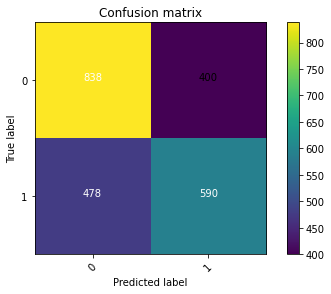

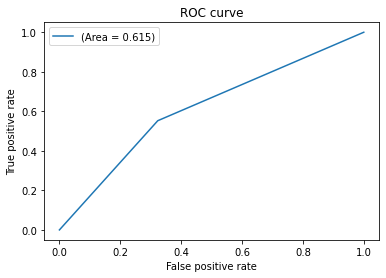

In [175]:
model.analyze(train)

In [ ]:
super_model = TSTransformerEncoderLSTM(feat_dim,max_len,128,16,3,256,2,lstm_layers=2,hidden_size=128,dropout=0.1)

In [79]:
supervised = train_model(super_model)

Epoch 0: 55.241%
Epoch 1: 57.099%
Epoch 2: 58.349%
Epoch 3: 58.864%
Epoch 4: 60.545%
Epoch 5: 61.537%
Epoch 6: 62.479%
Epoch 7: 64.02%
Epoch 8: 66.153%
Epoch 9: 67.842%
Epoch 10: 69.552%
Epoch 11: 71.748%
Epoch 12: 72.952%
Epoch 13: 75.971%
Epoch 14: 77.386%
Epoch 15: 78.568%
Epoch 16: 80.363%
Epoch 17: 81.609%
Epoch 18: 83.171%
Epoch 19: 83.425%
Epoch 20: 84.734%
Epoch 21: 86.254%
Epoch 22: 86.465%
Epoch 23: 87.141%
Epoch 24: 87.162%
Epoch 25: 88.302%
Epoch 26: 88.936%
Epoch 27: 89.949%
Epoch 28: 89.949%
Epoch 29: 90.519%
Epoch 30: 91.322%
Epoch 31: 91.343%
Epoch 32: 91.596%
Epoch 33: 91.427%
Epoch 34: 92.483%
Epoch 35: 91.892%
Epoch 36: 92.483%
Epoch 37: 93.581%
Epoch 38: 93.644%
Epoch 39: 92.927%
Epoch 40: 93.412%
Epoch 41: 93.644%
Epoch 42: 93.877%
Epoch 43: 93.982%
Epoch 44: 94.785%
Epoch 45: 94.658%
Epoch 46: 95.08%
Epoch 47: 94.679%
Epoch 48: 94.679%
Epoch 49: 95.545%
Epoch 50: 94.827%
Epoch 51: 95.587%
Epoch 52: 95.524%
Epoch 53: 95.165%
Epoch 54: 94.954%
Epoch 55: 96.052%
Epoc

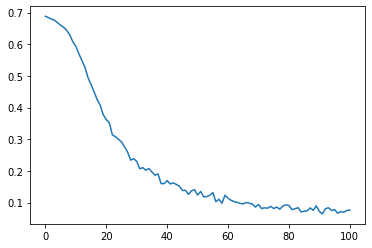

In [35]:
supervised.train(train, verbose=True, return_loss=True, 
                 epochs= 100, batch_size=128)

In [36]:
supervised.evaluate(val,batch_size=128)

{'mean batch accuracy': 0.4699519230769231}


Accuracy:  0.5369607630609148

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.57      0.63      3236
           1       0.31      0.47      0.38      1377

    accuracy                           0.54      4613
   macro avg       0.51      0.52      0.50      4613
weighted avg       0.60      0.54      0.56      4613


Confusion Matrix:

             Total lenght of Data: 4613 

             Class 0: 2562
             Class 1: 2051 

Confusion matrix, without normalization
[[1831 1405]
 [ 731  646]]




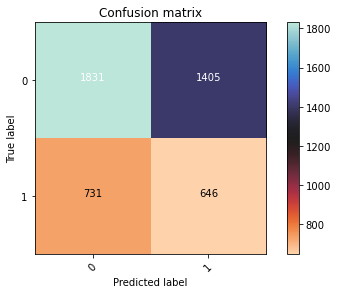

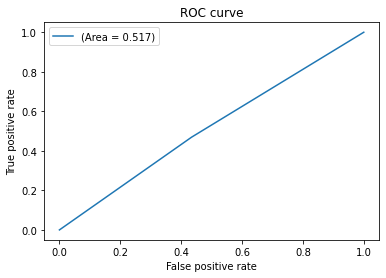

In [94]:
supervised.analyze(train,color='icefire_r')

In [442]:
#from torchviz import make_dot

In [1372]:
class pretrain():
    
    def __init__(self,model):
        self.model = model
        self.loss_module = nn.MSELoss()
        self.epoch_metrics = {}
        self.total_loss = 0
        self.batch_loss = []
        
        
    def train(self,data, batch_size=20,epochs=100,verbose=True,return_loss=False):
        self.model = self.model.train()
        self.data = data
        self.verbose = verbose
        self.return_loss = return_loss
        self.batch_size = batch_size
        self.epochs = epochs
  

        for epoch in range(self.epochs):
    
            total_batch_loss = 0
            total_loss = 0
    
            for i, batch in enumerate(DataLoader(self.data,self.batch_size)):
                masked_data, targets, target_masks, padding_masks = batch
                prediction = self.model(masked_data,padding_masks)
                masked_prediction = torch.masked_select(prediction,target_masks)
                masked_true = torch.masked_select(targets, target_masks)
                optimizer = optim.Adam(self.model.parameters())
                loss = self.loss_module(masked_prediction, masked_true)
        
                total_loss +=loss
                mean_batch_loss = total_loss/(i+1)
        
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=4.0)
                optimizer.step()
        
                metrics = {'mean batch loss':mean_batch_loss.item()}
        
        
            self.batch_loss.append(mean_batch_loss.detach().numpy())
            if self.verbose:
                print('Epoch {}: {}'.format(epoch,round(mean_batch_loss.item(),3)))
            self.total_loss += mean_batch_loss
            self.epoch_metrics['Epoch'] = epoch
            self.epoch_metrics['Loss'] = self.total_loss/(epoch+1)
        
        if self.return_loss:
            return plt.plot(self.batch_loss)
        else:
            return self.epoch_metrcrics['Loss']
        
        
    def evaluate(self,data,batch_size=20):
            self.data = data
            self.batch_size = batch_size
            total_batch_loss = 0
            self.model = self.model.eval()
            
            for i, batch in enumerate(DataLoader(self.data, self.batch_size)):
                masked_data, targets, target_masks, padding_masks = batch
                prediction = self.model(masked_data, padding_masks)
                masked_prediction = torch.masked_select(prediction,target_masks)
                masked_true = torch.masked_select(targets, target_masks)
                
                batch_loss = self.loss_module(masked_prediction, masked_true)
                total_batch_loss += batch_loss
                mean_bach_loss = total_batch_loss/(i+1)
            metrics = {'mean batch loss':mean_bach_loss.item()}
                
            return metrics

In [1439]:
unsuper_model = TSTransformerEncoder(feat_dim,max_len,32,16,3,128)

In [1440]:
unsupervised = pretrain(unsuper_model)

Epoch 0: 0.178
Epoch 1: 0.178
Epoch 2: 0.176
Epoch 3: 0.178
Epoch 4: 0.177
Epoch 5: 0.176
Epoch 6: 0.176
Epoch 7: 0.175
Epoch 8: 0.176
Epoch 9: 0.175
Epoch 10: 0.176
Epoch 11: 0.174
Epoch 12: 0.175
Epoch 13: 0.174
Epoch 14: 0.174
Epoch 15: 0.174
Epoch 16: 0.173
Epoch 17: 0.174
Epoch 18: 0.173
Epoch 19: 0.173
Epoch 20: 0.173
Epoch 21: 0.172
Epoch 22: 0.171
Epoch 23: 0.173
Epoch 24: 0.171
Epoch 25: 0.17
Epoch 26: 0.171
Epoch 27: 0.17
Epoch 28: 0.171
Epoch 29: 0.17
Epoch 30: 0.17
Epoch 31: 0.17
Epoch 32: 0.169
Epoch 33: 0.169
Epoch 34: 0.168
Epoch 35: 0.168
Epoch 36: 0.168
Epoch 37: 0.168
Epoch 38: 0.167
Epoch 39: 0.167
Epoch 40: 0.168
Epoch 41: 0.166
Epoch 42: 0.166
Epoch 43: 0.167
Epoch 44: 0.167
Epoch 45: 0.166
Epoch 46: 0.166
Epoch 47: 0.167
Epoch 48: 0.166
Epoch 49: 0.165
Epoch 50: 0.167
Epoch 51: 0.165
Epoch 52: 0.165
Epoch 53: 0.164
Epoch 54: 0.165
Epoch 55: 0.165
Epoch 56: 0.164
Epoch 57: 0.163
Epoch 58: 0.163
Epoch 59: 0.164
Epoch 60: 0.163
Epoch 61: 0.162
Epoch 62: 0.163
Epoch 6

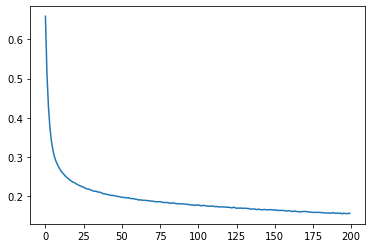

In [1444]:
unsupervised.train(train_mask_data,verbose=True, return_loss=True,epochs=100,batch_size=128)

In [1445]:
unsupervised.evaluate(test_mask_data)

{'mean batch loss': 3.1651411056518555}

In [1446]:
unsupervised.evaluate(train_mask_data)

{'mean batch loss': 0.13050149381160736}

In [1447]:
feat_dim*max_len

990

In [1448]:
class unsupervised_model(nn.Module):
    
    def __init__(self,model,d_model, max_len, num_classes):
        super(unsupervised_model, self).__init__()
        
        self.model = model
        self.linear = nn.Linear(d_model * max_len, num_classes)
        self.loss_module = nn.CrossEntropyLoss()
        
    def forward(self, X, padding_masks):
        
        prediction = self.model(X, padding_masks)
        prediction = prediction.reshape(prediction.shape[0], -1)
        output = self.linear(prediction)
       
        return output

In [1449]:
pretrained_model = unsupervised_model(unsuper_model,feat_dim,max_len,n_class)

In [183]:
pretrain_supervised = train_model(pretrained_model)

NameError: name 'pretrained_model' is not defined

Epoch 0: 54.387%
Epoch 1: 58.774%
Epoch 2: 63.101%
Epoch 3: 67.368%
Epoch 4: 68.99%
Epoch 5: 71.575%
Epoch 6: 74.579%
Epoch 7: 75.18%
Epoch 8: 78.305%
Epoch 9: 79.327%
Epoch 10: 79.447%
Epoch 11: 79.928%
Epoch 12: 81.19%
Epoch 13: 82.091%
Epoch 14: 84.135%
Epoch 15: 84.375%
Epoch 16: 83.534%
Epoch 17: 83.474%
Epoch 18: 84.916%
Epoch 19: 82.933%
Epoch 20: 84.375%
Epoch 21: 84.195%
Epoch 22: 85.036%
Epoch 23: 85.216%
Epoch 24: 85.276%
Epoch 25: 85.216%
Epoch 26: 86.779%
Epoch 27: 85.877%
Epoch 28: 86.779%
Epoch 29: 87.56%
Epoch 30: 86.659%
Epoch 31: 86.899%
Epoch 32: 87.981%
Epoch 33: 87.079%
Epoch 34: 88.221%
Epoch 35: 87.74%
Epoch 36: 88.281%
Epoch 37: 88.221%
Epoch 38: 88.401%
Epoch 39: 88.462%
Epoch 40: 89.603%
Epoch 41: 88.822%
Epoch 42: 89.904%
Epoch 43: 88.161%
Epoch 44: 89.363%
Epoch 45: 90.745%
Epoch 46: 90.084%
Epoch 47: 88.882%
Epoch 48: 89.844%
Epoch 49: 90.385%
Epoch 50: 91.286%
Epoch 51: 90.865%
Epoch 52: 89.603%
Epoch 53: 89.123%
Epoch 54: 90.445%
Epoch 55: 91.106%
Epoch 5

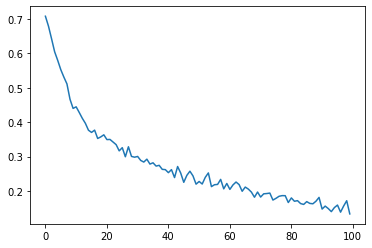

In [1451]:
pretrain_supervised.train(train_data,epochs=100,verbose=True,return_loss=True)

In [1452]:
pretrain_supervised.evaluate(test_data,batch_size=64)

{'mean batch accuracy': 0.47478991596638653}

In [1381]:
class unsupervised_lstm_model(nn.Module):
    
    def __init__(self,model,d_model, max_len, num_classes):
        super(unsupervised_lstm_model, self).__init__()
        
        self.model = model
        self.linear = nn.Linear(d_model * max_len, num_classes)
        self.loss_module = nn.CrossEntropyLoss()
        self.output_layer = self.linear(num_classes)
        self.lstm = nn.LSTM(d_model,30,1,batch_first=True)
        self.dropout = nn.Dropout(0.3)
        
    def linear(self,num_classes):
        output_layer = nn.Linear(30,num_classes)
        # no softmax (or log softmax), because CrossEntropyLoss does this internally. If probabilities are needed,
        # add F.log_softmax and use NLLoss
        return output_layer

    def forward(self, X, padding_masks):
        
        prediction = self.model(X, padding_masks)
        h0=c0= torch.zeros(1,prediction.size(0),30)
        output, (hn, cn) = self.lstm(prediction, (h0,c0)) 
        hn = hn.view(-1,30)
        output = self.output_layer(hn)
        output = self.dropout(output)
        return output       
         

In [1382]:
pretrain_model_lstm = unsupervised_lstm_model(unsuper_model,feat_dim,max_len,n_class)

In [1383]:
pretrain_supervised = train_model(pretrain_model_lstm)

Epoch 0: 87.56%
Epoch 1: 86.779%
Epoch 2: 86.779%
Epoch 3: 87.019%
Epoch 4: 88.041%
Epoch 5: 87.38%
Epoch 6: 87.5%
Epoch 7: 87.981%
Epoch 8: 86.298%
Epoch 9: 87.56%


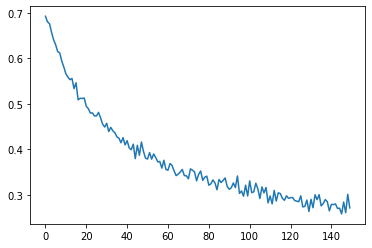

In [1419]:
pretrain_supervised.train(train_data,epochs=10,verbose=True,return_loss=True)

In [1420]:
pretrain_supervised.evaluate(test_data)

{'mean batch accuracy': 0.5446428571428572}

In [9]:
import torch

In [3]:
from preprocess import train_model
from preprocess import data_preprocess

In [27]:
name = 'UAL'

In [28]:
preprocess = data_preprocess()

In [29]:
preprocess.get_data(name=name, path ='/users/abhijitdeshpande/documents/project files/full hourly data/',days=15)

In [30]:
train, val, test, feat_dim, max_len = preprocess.prepare_data(supervised=True)

Total Samples: 5604
Training Samples: 3362
Validation Samples: 1120
Testing Samples: 1122


In [31]:
model = torch.load('/users/abhijitdeshpande/desktop/models/'+name)

In [32]:
supervised = train_model(model)


Accuracy:  0.5723214285714285

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       665
           1       0.47      0.48      0.48       455

    accuracy                           0.57      1120
   macro avg       0.56      0.56      0.56      1120
weighted avg       0.57      0.57      0.57      1120


Confusion Matrix:

             Total lenght of Data: 1120 

             Class 0: 656
             Class 1: 464 

Confusion matrix, without normalization
[[421 244]
 [235 220]]




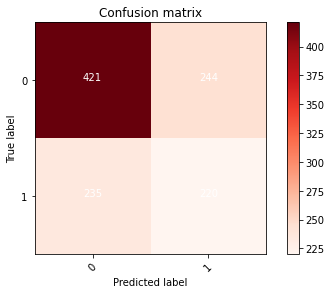

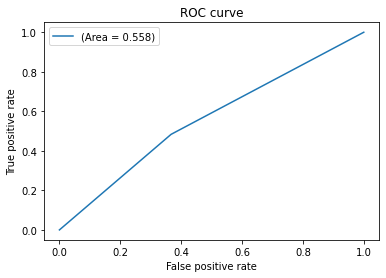

In [38]:
supervised.analyze(val,color='Reds')

In [116]:
from sklearn import svm

In [202]:
clf = svm.SVC(C=1)

In [203]:
from sklearn.preprocessing import StandardScaler

In [204]:
scaler = StandardScaler()

In [205]:
features = scaler.fit_transform(features)

In [206]:
train, val, test = features[:3300], features[3300:4400], features[4400:]
y_train, y_val, y_test = labels[:3300], labels[3300:4400], labels[4400:]

In [207]:
clf.fit(train, y_train)

SVC(C=1)

In [208]:
pred = clf.predict(test)

In [181]:
from sklearn.metrics import accuracy_score, classification_report

In [182]:
accuracy_score(pred, y_test)

NameError: name 'pred' is not defined

In [211]:
accuracy_score(pred, y_test)

0.5233798195242002

In [180]:
print(classification_report(pred,y_test))

NameError: name 'classification_report' is not defined

In [33]:
import sys
sys.maxsize

9223372036854775807

In [22]:
from modules import TSTransformerEncoderLSTM, TSTransformerEncoderClass

In [30]:
torch.manual_seed(10)
super_model = TSTransformerEncoderClass(45,15,64,4,1,
                                             128, 2, dropout=0.4)

In [31]:
super_model

TSTransformerEncoderClass(
  (project_inp): Linear(in_features=45, out_features=64, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (dropout1): Dropout(p=0.4, inplace=False)
  (out